In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [4]:
data = pd.read_csv("../databases/PEPSIR_raw_LF_perfect.csv", sep=";")

In [5]:
data.head()

,river,day,reach,lon,lat,flowacc,sinuosity,meandwave,height,W,...,S,dA,K,A0,Abar,alpha,beta,Fr,U,Q
0,Connecticut,1,1,-72.611298,41.959,25078.300781,1.079975,1260.057129,26.306667,475.403333,...,0.001768,541.200050,12.808404,515.403333,821.447783,10.945707,0.225114,0.217360,0.965178,922.263333
1,Connecticut,2,1,-72.611298,41.959,25078.300781,1.079975,1260.057129,25.960000,443.906667,...,0.001606,381.870528,12.586607,515.403333,821.447783,10.945707,0.225114,0.165027,0.704906,581.980000
2,Connecticut,3,1,-72.611298,41.959,25078.300781,1.079975,1260.057129,25.810000,427.006667,...,0.001539,316.600322,12.513133,515.403333,821.447783,10.945707,0.225114,0.141175,0.595232,460.586667
3,Connecticut,4,1,-72.611298,41.959,25078.300781,1.079975,1260.057129,25.776667,423.786667,...,0.001521,302.424628,12.499948,515.403333,821.447783,10.945707,0.225114,0.135371,0.569428,435.253333
4,Connecticut,5,1,-72.611298,41.959,25078.300781,1.079975,1260.057129,25.616667,406.016667,...,0.001469,236.099400,12.410309,515.403333,821.447783,10.945707,0.225114,0.113845,0.471288,334.273333


# Computation of $\alpha$ and $\beta$ Strickler power law parameters using the Low-Froude model

In [7]:
# Get data for GaronneUpstream river section
river_data = data[data["river"] == "Connecticut"]

In [8]:
# Get data for 1st reach of GaronneUpstream river section
reach_data = river_data[river_data["reach"] == 1]

In [9]:
# Get variables and compute terms in Low-Froude equation (r=1 in this case)
A0r = reach_data["A0"]
dArp = reach_data["dA"]
Qrp = reach_data["Q"]
Srp = reach_data["S"]
Wrp = reach_data["W"]
Zrp = reach_data["height"]
Zr0 = np.min(Zrp)
Wr0 = np.min(Wrp)
c1rp = Wrp**(-2./5.) * Srp**(3./10.)
c2rp = c1rp * dArp
c3rp = (Zrp - Zr0)
c4r = 1.0 / Wr0

Rewriting the Low-Froude equation as:
$\frac{Q^{3/5}}{c^{(1)}_{r,p} A_{0,r} + c^{(2)}_{r,p}} = \alpha_r^{3/5} \left( c^{(4)}_{r,p} A_{0,r} + c^{(3)}_{r,p} \right)^{3/5 \beta_r}$
<br>
And setting $x=\left( c^{(4)}_{r,p} A_{0,r} + c^{(3)}_{r,p} \right)$, $y=\frac{Q^{3/5}}{c^{(1)}_{r,p} A_{0,r} + c^{(2)}_{r,p}}$, $a=\alpha_r^{3/5}$ and $b=3/5 \beta_r$,
The Low-Froude equation is then: $y=a x^b$
<br>
It is then easy to find a and b, using a linear regression between $\ln(y)$ and $\ln(x)$ and consequently the values of $\alpha$ and $\beta$


In [10]:
# Compute linear regression between log(x) and log(y)
x = c4r * A0r + c3rp
y = Qrp**(3./5.) / (c1rp * A0r + c2rp)
res = linregress(np.log(x), np.log(y))
                 
# Compute alpha and beta
a = res.slope
b = res.intercept
alpha = np.exp(b)**(5./3.)
beta = a * 5. / 3.
print("alpha=", alpha)
print("beta =", beta)

alpha= 0.987284391195017
beta = 2.0935261904769273


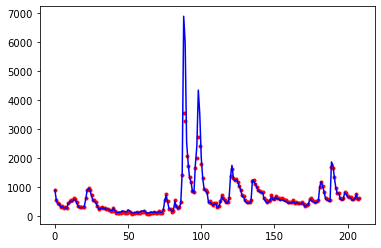

In [11]:
# Check our estimation using the Low-Froude model and computed values of alpha and beta
Qest = (alpha**(3./5.) * (c1rp * A0r + c2rp) * (c4r * A0r + c3rp)**(3./5. * beta))**(5./3.)
plt.plot(Qrp, 'r.')
plt.plot(Qest, 'b-')

# Useful metrics

## Standard metrics

- Pearson correlation coefficient $R2(y) = \frac{\sum_{i=1}^{n}(y^{est}_i - \bar y^{est}) (y^{obs}_i - \bar y^{obs})} {\left(\sum_{i=1}^{n}(y^{est}_i - \bar y^{est})^2\right)^{1/2}\left(\sum_{i=1}^{n}(y^{obs}_i - \bar y^{obs})^2\right)^{1/2}}$
<br>
<br>
- Root Mean Square Error $RMSE(y) = \sqrt {\frac{1}{n} \left( \sum^n_{i=1}(y^{est}_i - y^{obs}_i)^2 \right)}$
<br>
<br>

## Other useful metrics in hydrology (hence for discharge values mainly/only)

- Normalized Root Mean Square Error $nRMSE(y) = \frac{RMSE(y)} {\bar y^{obs}}$
<br>
<br>
- Nash-Sutcliffe model Efficiency $NSE(y) = 1 - \frac{\sum^n_{i=1}(y^{est}_i - y^{obs}_i)^2} {\sum^n_{i=1}(y^{obs}_i - \bar y^{obs})^2}$
<br>
<br>
- Kling-Gupta model Efficiency $KGE(y) = 1 - \sqrt {(\beta_{KG}-1)^2+(\alpha_{KG}-1)^2+(R^2-1)^2}$, with $\beta_{KG}=\frac{\bar y^{est}}{\bar y^{obs}}$ and $\alpha_{KG} = \frac{\sigma(y^{est})}{\sigma(y^{obs})}$